# 6. Decision Trees and Ensemble Learning

This week, we'll talk about decision trees and tree-based ensemble algorithms

# 6.1 Credit risk scoring project

Dataset: https://github.com/gastonstat/CreditScoring

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# 6.2 Data cleaning and preparation

- Downloading the dataset
- Re-encoding the categorical variables
- Doing the train/validation/test split

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
!wget $data

'wget' não é reconhecido como um comando interno
ou externo, um programa operável ou um arquivo em lotes.


In [4]:
!head CreditScoring.csv

'head' não é reconhecido como um comando interno
ou externo, um programa operável ou um arquivo em lotes.


In [5]:
df = pd.read_csv(data)

In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [8]:
df.status # status is a categorical var

0       1
1       1
2       2
3       1
4       1
       ..
4450    2
4451    1
4452    2
4453    1
4454    1
Name: status, Length: 4455, dtype: int64

In [9]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [10]:
df.status.map({1: 'ok', 2: 'default', 0: 'unk'})

0            ok
1            ok
2       default
3            ok
4            ok
         ...   
4450    default
4451         ok
4452    default
4453         ok
4454         ok
Name: status, Length: 4455, dtype: object

In [11]:
status_values = {
    1: 'ok', 
    2: 'default', 
    0: 'unk'
}

df.status = df.status.map(status_values)

In [12]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [13]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [14]:
# Missing values -> the income 9999999 is a NaN

df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [15]:
df.income.max()

99999999

In [16]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [17]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [18]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

In [19]:
df = df[df.status !='unk'].reset_index(drop=True)

df

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,default,1,rent,60,39,married,no,fixed,69,92.0,0.0,0.0,900,1020
4450,ok,22,owner,60,46,married,no,fixed,60,75.0,3000.0,600.0,950,1263
4451,default,0,owner,24,37,married,no,partime,60,90.0,3500.0,0.0,500,963
4452,ok,0,rent,48,23,single,no,freelance,49,140.0,0.0,0.0,550,550


In [20]:
# Train/Val/Test Split

from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [21]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [22]:
# Remove the default variable from the dataframe

df_train.status

0       default
1       default
2            ok
3       default
4            ok
         ...   
2667         ok
2668         ok
2669         ok
2670         ok
2671         ok
Name: status, Length: 2672, dtype: object

In [23]:
(df_train.status == 'default').astype('int')

0       1
1       1
2       0
3       1
4       0
       ..
2667    0
2668    0
2669    0
2670    0
2671    0
Name: status, Length: 2672, dtype: int32

In [24]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [25]:
del df_train['status']
del df_val['status']
del df_test['status']

In [26]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


# 6.3 Decision trees

- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

In [27]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'    

In [28]:
xi = df_train.iloc[0].to_dict()

In [29]:
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [30]:
assess_risk(xi)

'ok'

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer # we need this library because of categorical vars
from sklearn.metrics import roc_auc_score

In [32]:
train_dicts = df_train.to_dict(orient='records')

In [33]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [34]:
X_train

array([[3.60e+01, 1.00e+03, 1.00e+04, ..., 0.00e+00, 1.00e+01, 3.60e+01],
       [3.20e+01, 1.10e+03, 0.00e+00, ..., 1.00e+00, 6.00e+00, 4.80e+01],
       [4.00e+01, 1.32e+03, 0.00e+00, ..., 0.00e+00, 1.00e+00, 4.80e+01],
       ...,
       [1.90e+01, 4.00e+02, 0.00e+00, ..., 0.00e+00, 1.00e+00, 2.40e+01],
       [4.30e+01, 2.50e+03, 1.80e+04, ..., 0.00e+00, 1.50e+01, 4.80e+01],
       [2.70e+01, 4.50e+02, 5.00e+03, ..., 1.00e+00, 1.20e+01, 4.80e+01]])

In [35]:
list(dv.get_feature_names_out())

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

In [36]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# the error is because there are numerical values NaN

ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [37]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [38]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [39]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [40]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [41]:
y_pred = dt.predict_proba(X_val)

y_pred

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [42]:
roc_auc_score(y_val, y_pred)

# the error is because it should be a 1D array, but its a 2D array

ValueError: y should be a 1d array, got an array of shape (891, 2) instead.

In [43]:
y_pred = dt.predict_proba(X_val)[:, 1] # we just need the 2nd column (if the customer belongs to the positive class)

y_pred

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0.

In [44]:
roc_auc_score(y_val, y_pred)

0.6600560654864256

In [45]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

# this is overfitting: and excellent score on training dataset, and
# a very worse one on validation dataset

1.0

In [46]:
y_train[0] # default value of xi

1

In [47]:
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

- in this case, overfitting happened because of the unrestricted depth of the tree

In [48]:
# Controlling and restricting the depth of the tree

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [49]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', round(auc, 3))

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', round(auc, 3))

train: 0.705
val: 0.669


In [50]:
# Visualize the tree

from sklearn.tree import export_text

In [51]:
feature_names = dv.get_feature_names_out().tolist()

if len(feature_names) > 0:
    print(export_text(dt, feature_names=feature_names))
else:
    print("Feature names array is empty.")

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



# 6.4 Decision Tree Learning Algorithm

- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

In [52]:
data = [                # 1st column = assets
    [8000, 'default'],  # 2nd column = status
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

# we will train the decision tree with the assets column

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [53]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [54]:
# Potential thresholds
# - we don't include 9000 because this threshold woulnd't divide the dataset into 2 parts (left and right)
# - we need to test each threshold and see which is the best

Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [55]:
from IPython.display import display

In [56]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]  
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))
    
    print()
    
# with these values, we can build a table to compare all the thresholds nad the impurity rate of left and right

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



In [57]:
# Dataset with 2 features

data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [58]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [59]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000],
}

In [60]:
for feature, Ts in thresholds.items():
    print('###################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example.assets <= T]
        df_right = df_example[df_example.assets > T]  

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print('###################')
        print()
    
# with these values, we can build a table to compare all the thresholds nad the impurity rate of left and right

###################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
###################

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
###################

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
###################

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
###################

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
###################

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64
###################

###################
debt
500


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
###################

1000


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
###################

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
###################



# 6.5 - Decision Trees Parameter Tuning

- selecting max_depth
- selecting min_samples_leaf

In [61]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]: # None = no restriction
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d, auc))
    
    # - the values for 4, 5 or 6 are all good
    # - we're going to choose 4 layers, because the score is good and
    #   it is simpler

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.754
  10 -> 0.683
  15 -> 0.667
  20 -> 0.652
None -> 0.660


In [62]:
scores = []

for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]: # s = samples leaf
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, s, auc))

In [63]:
columns = ['max_depth', 'min_samples_leaf', 'auc']

df_scores = pd.DataFrame(scores, columns=columns)

df_scores.head()

,max_depth,min_samples_leaf,auc
0,4.0,1,0.761283
1,4.0,2,0.761283
2,4.0,5,0.761283
3,4.0,10,0.761283
4,4.0,15,0.763726


In [64]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
40,10.0,15,0.791522
67,NaN,15,0.787390
49,15.0,15,0.786827
58,20.0,15,0.785973
22,6.0,15,0.784856


In [65]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', 
                                  columns=['max_depth'],
                                   values=['auc'])

df_scores_pivot.round(3)

auc                                                 
max_depth           NaN   4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                        
1                 0.646  0.761  0.767  0.745  0.740  0.695  0.667  0.648
2                 0.685  0.761  0.767  0.763  0.756  0.713  0.689  0.693
5                 0.716  0.761  0.768  0.760  0.759  0.732  0.718  0.717
10                0.761  0.761  0.762  0.778  0.764  0.766  0.758  0.757
15                0.787  0.764  0.772  0.785  0.779  0.792  0.787  0.786
20                0.783  0.761  0.774  0.774  0.781  0.784  0.782  0.782
100               0.779  0.756  0.763  0.776  0.780  0.780  0.780  0.779
200               0.768  0.747  0.759  0.768  0.768  0.768  0.768  0.768
500               0.680  0.680  0.680  0.680  0.680  0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

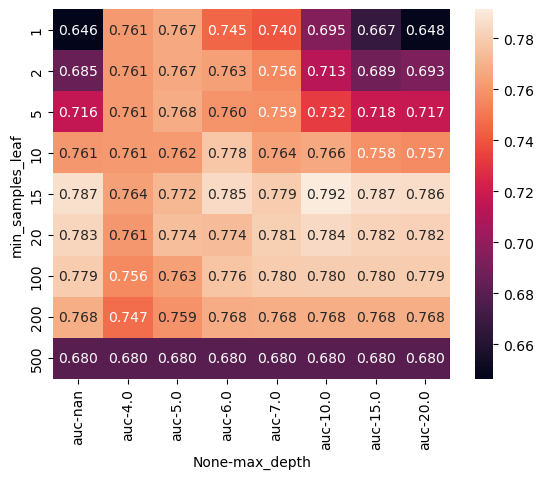

In [66]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

- we'll choose the max_depth=6 and min_samples_leaf=15. Even though unrestricted max_depth brings a better result, it can be dangerous

In [67]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

# 6.6 Ensembles and random forest

- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [70]:
y_pred = rf.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred) # this score is as good as our best decision tree

0.7744726453706618

In [71]:
rf.predict_proba(X_val[[0]])

array([[0.9, 0.1]])

In [72]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [73]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores.round(3)

,n_estimators,auc
0,10,0.774
1,20,0.804
2,30,0.815
3,40,0.816
4,50,0.817
5,60,0.816
6,70,0.817
7,80,0.816
8,90,0.817
9,100,0.818


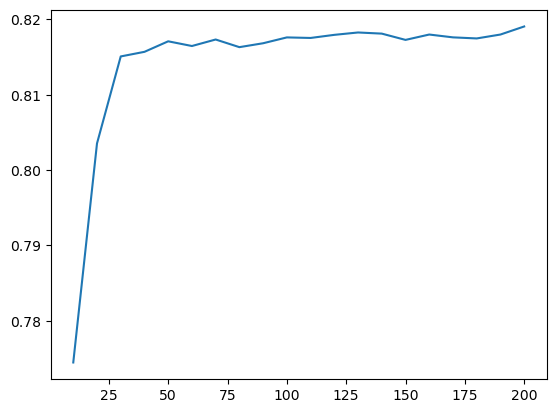

In [74]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [75]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=d, 
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [76]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


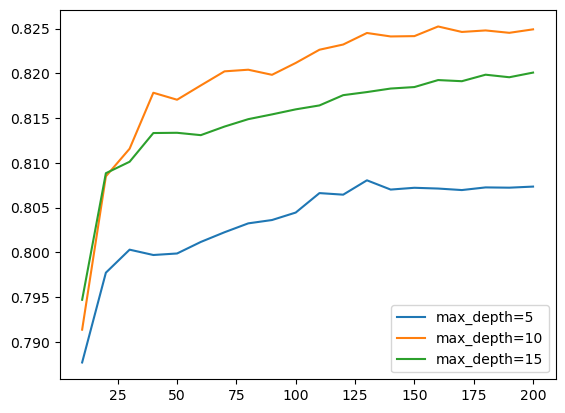

In [77]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, 
             label='max_depth=%d' % d)
    
plt.legend()

# this plot shows us that max_depth=10 is the best

In [78]:
max_depth = 10

In [79]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [80]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058


In [81]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf = [1, 3, 5, 10, 50]
list(zip(min_samples_leaf, colors))

[(1, 'black'), (3, 'blue'), (5, 'orange'), (10, 'red'), (50, 'grey')]

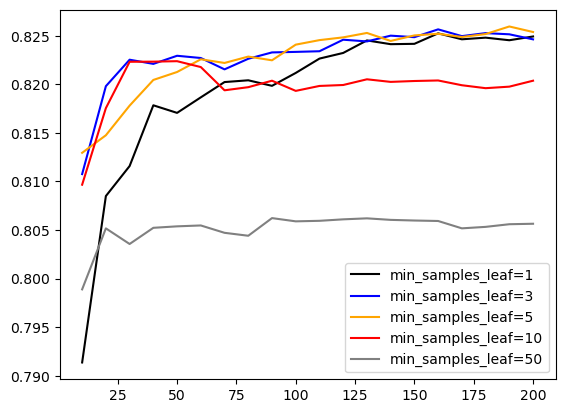

In [82]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf = [1, 3, 5, 10, 50]

for s, col in zip(min_samples_leaf, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)
    
plt.legend()

# this plot shows us that max_depth=10 is the best

In [83]:
min_samples_leaf = 3

In [84]:
# Final model (n_estimators=200, max_depth=10, min_samples_leaf=3)

rf = RandomForestClassifier(n_estimators=200, 
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1,
                           n_jobs=-1)

rf.fit(X_train, y_train)

# there are still some other parameters that we could tune

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1, random_state=1)

In [85]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

In [86]:
auc

0.8246258264512848

# 6.7 Gradient boosting and XGBoost

- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

In [87]:
!pip install xgboost

In [88]:
import xgboost as xgb

In [89]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [90]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1, # this is similar to min_samples_leaf
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, # 0-suppress warnings, 2-displays lots of thing
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [91]:
y_pred = model.predict(dval)

In [92]:
roc_auc_score(y_val, y_pred)

0.8065256351262986

In [93]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [94]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1, # this is similar to min_samples_leaf
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
   
    'nthread': 8,
    'seed': 1,
    'verbosity': 1, # 0-suppress warnings, 2-displays lots of thing
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist, 
                 )

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206
[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.0000

In [95]:
%%capture output
# this command captures the print

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1, # this is similar to min_samples_leaf
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, # 0-suppress warnings, 2-displays lots of thing
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist, 
                 )

In [96]:
print(output.stdout)

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206
[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.0000

In [97]:
s = output.stdout

In [98]:
s.split('\n') # this replaces the spaces with a slash \

['[0]\ttrain-auc:0.86730\tval-auc:0.77938',
 '[5]\ttrain-auc:0.93086\tval-auc:0.80858',
 '[10]\ttrain-auc:0.95447\tval-auc:0.80851',
 '[15]\ttrain-auc:0.96554\tval-auc:0.81334',
 '[20]\ttrain-auc:0.97464\tval-auc:0.81729',
 '[25]\ttrain-auc:0.97953\tval-auc:0.81686',
 '[30]\ttrain-auc:0.98579\tval-auc:0.81543',
 '[35]\ttrain-auc:0.99011\tval-auc:0.81206',
 '[40]\ttrain-auc:0.99421\tval-auc:0.80922',
 '[45]\ttrain-auc:0.99548\tval-auc:0.80842',
 '[50]\ttrain-auc:0.99653\tval-auc:0.80918',
 '[55]\ttrain-auc:0.99765\tval-auc:0.81114',
 '[60]\ttrain-auc:0.99817\tval-auc:0.81172',
 '[65]\ttrain-auc:0.99887\tval-auc:0.80798',
 '[70]\ttrain-auc:0.99934\tval-auc:0.80870',
 '[75]\ttrain-auc:0.99965\tval-auc:0.80555',
 '[80]\ttrain-auc:0.99979\tval-auc:0.80549',
 '[85]\ttrain-auc:0.99988\tval-auc:0.80374',
 '[90]\ttrain-auc:0.99993\tval-auc:0.80409',
 '[95]\ttrain-auc:0.99996\tval-auc:0.80548',
 '[100]\ttrain-auc:0.99998\tval-auc:0.80509',
 '[105]\ttrain-auc:0.99999\tval-auc:0.80629',
 '[110]\tt

In [99]:
line = s.split('\n')[0]

In [100]:
line

'[0]\ttrain-auc:0.86730\tval-auc:0.77938'

In [101]:
line.split('\t')

['[0]', 'train-auc:0.86730', 'val-auc:0.77938']

In [102]:
num_iter, train_auc, val_auc = line.split('\t')

In [103]:
int(num_iter.strip('[]'))

0

In [104]:
train_auc

'train-auc:0.86730'

In [105]:
train_auc.split(':')

['train-auc', '0.86730']

In [106]:
float(train_auc.split(':')[1])

0.8673

In [107]:
float(val_auc.split(':')[1])

0.77938

In [108]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [109]:
df_score = parse_xgb_output(output)

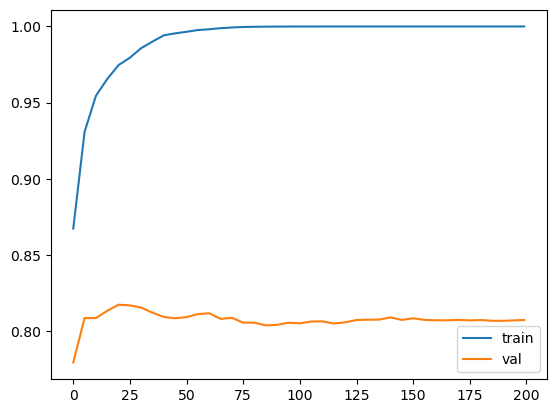

In [110]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

# when train gets to 1 and val decreases (around num_iter=60), it overfits

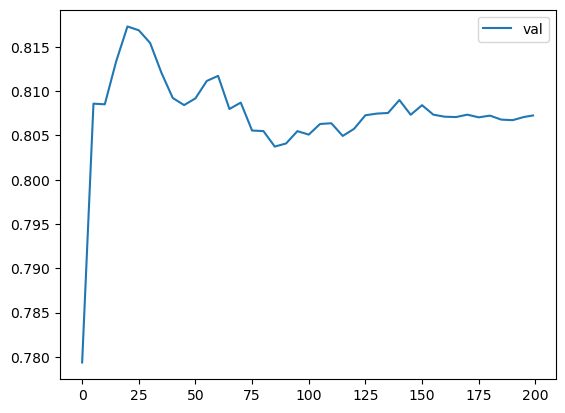

In [111]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

# 6.8 - XGBoost Parameter Tuning

#### Tuning the following parameters:
- eta
- max_depth
- min_child_weight

In [112]:
scores = {}

In [132]:
%%capture output
# this command captures the print

xgb_params = {
    'eta': 1.0, 
    # to get the different etas in the keys dict (below), needs to change here and in the cell below and run the script
    'max_depth': 6,
    'min_child_weight': 1, # this is similar to min_samples_leaf
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1, # 0-suppress warnings, 2-displays lots of thing
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [133]:
'eta=%s' % (xgb_params['eta'])

'eta=1.0'

In [134]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

key

'eta=1.0'

In [135]:
scores['eta=1.0']

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.95857,0.79136
2,10,0.98061,0.78355
3,15,0.99549,0.78050
4,20,0.99894,0.78591
5,25,0.99989,0.78401
6,30,1.00000,0.78371
7,35,1.00000,0.78234
8,40,1.00000,0.78184
9,45,1.00000,0.77963


In [136]:
scores.keys()

dict_keys(['eta=0.01', 'eta=0.05', 'eta=0.1', 'eta=0.3', 'eta=1.0'])

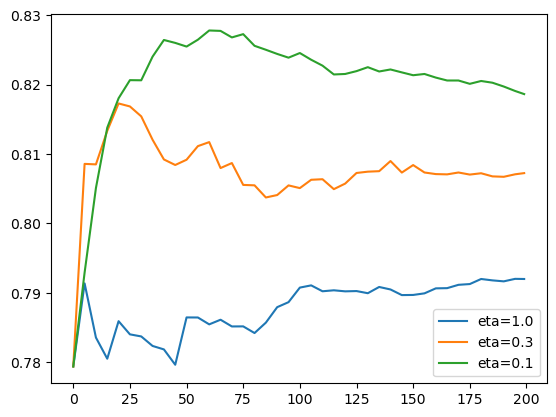

In [137]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
    
plt.legend()

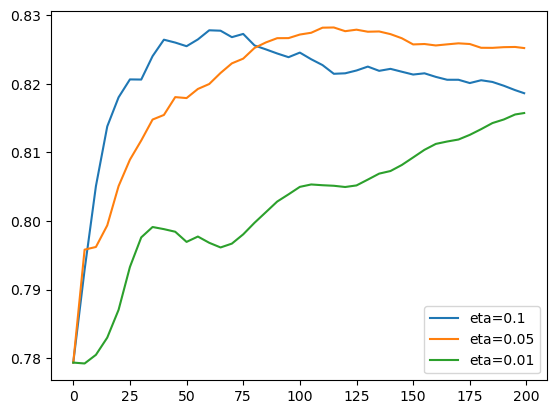

In [138]:
etas = ['eta=0.1', 'eta=0.05', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
    
plt.legend()

#### eta = 0.1 is the best

Now, we're going to tune max_depth

In [150]:
scores = {}

In [157]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10, # test max_depth for 6, 3, 4, 10
    'min_child_weight': 1, # this is similar to min_samples_leaf
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
  
    'nthread': 8,
    'seed': 1,
    'verbosity': 1, # 0-suppress warnings, 2-displays lots of thing
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [158]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

key

'max_depth=10'

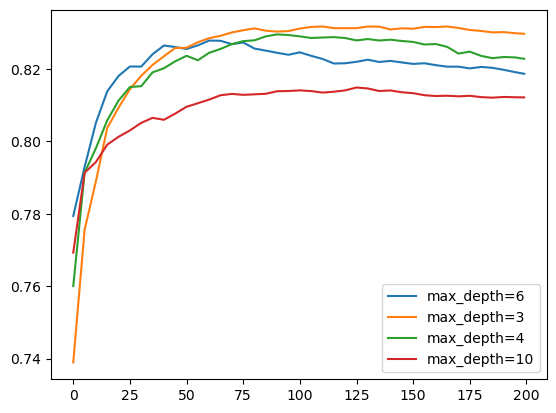

In [159]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
    
plt.legend()

In [160]:
# - red curve (max_depth=10) is the worst, so we're going to delete it
#   to see the other curves better

del scores['max_depth=10']

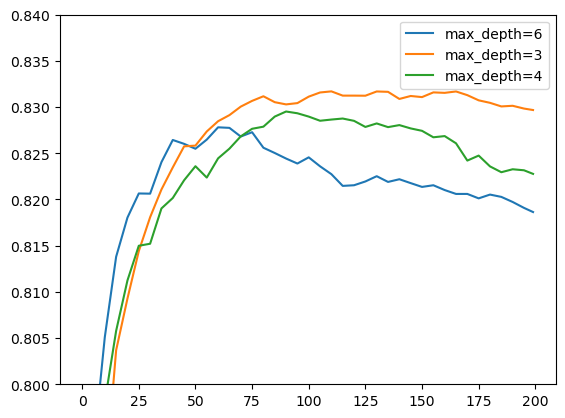

In [161]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

#### - max depth=3 is the best value, because
    - it takes longer to get to the peak, but this is because is has max_depth 
    of 3, which means it is a simple tree, and we need more trees compared to
    bigger values of depth
    - peak is higher than max_depth=4 or 6
    
Last, we`re going to tune min_child_weight

In [184]:
scores = {}

In [189]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3, 
    'min_child_weight': 30, # test min_child_weight for 1, 10, 30
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
  
    'nthread': 8,
    'seed': 1,
    'verbosity': 1, # 0-suppress warnings, 2-displays lots of thing
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [190]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

key

'min_child_weight=30'

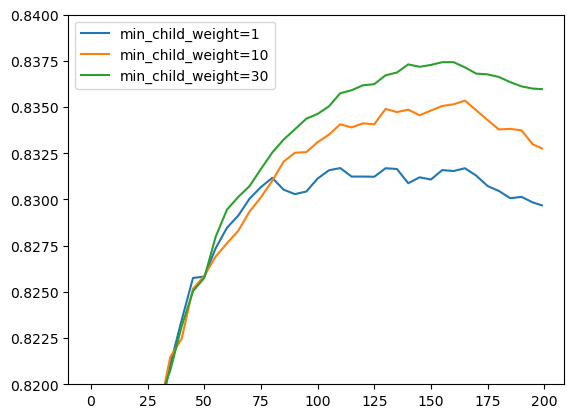

In [193]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()

# - this plot went wrong, min_child_weight=1 should be the best value
# - also, best number of iterations should be around 175

In [194]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:

- subsample and colsample_bytree
- lambda and alpha